In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np

from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_persistence, sublevelset_persistence, sublevelset_heading_persistence
from functions.data_loading import flights_from_query, get_flight_persistances
from functions.objects import PersistenceData, Models

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from traffic.core import Traffic, Flight

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
datasets = [("balanced1_2", True, True),("balanced1_2_3", False, False),("unbalanced1_2_3_4", False, False)]
name, simple, classification = datasets[1]

flights, data = flights_from_query(None, name, load_results=True)

pers_objects = get_flight_persistances(flights, name, load_results=True)
LL_data, A_data, S_data, H_data = pers_objects

weather_data = data[:, 1:]
labels = data[:, 0]
if simple: 
    labels = (labels != 1).astype(int)

C:\Users\tobso\Desktop\programering\masters-thesis\functions\objects.py:89: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(path[:, 0], path[:, 1], cmap="plasma", edgecolors="none")


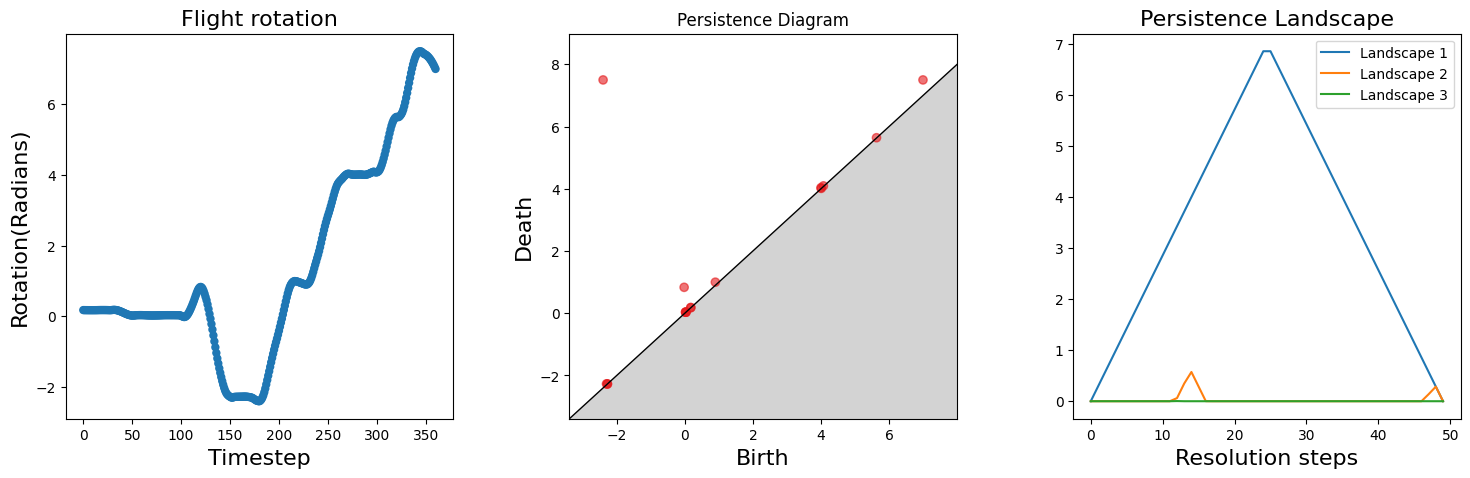

In [11]:
from gudhi.representations import Landscape

index = 3027
dataset = 3

pers = pers_objects[dataset]
pers.landscape_model = Landscape(num_landscapes=3, resolution=50, keep_endpoints=True)
pers.compute_landscapes()
fig = pers.plot_diagram(index, add_landscape=True)
#fig.savefig("H_example.svg", format="svg", dpi=1000)
pers.landscape_model = Landscape(num_landscapes=3, resolution=20, keep_endpoints=False)
pers.compute_landscapes()
None

In [12]:
from tqdm import tqdm
baseline = []

for flight in tqdm(flights, total=len(flights)):
    data = flight.data.copy(deep=True)
    
    unwrapped = np.unwrap(np.deg2rad(data["track"]), period=2 * np.pi, discont=np.pi)
    max_unwrapped = unwrapped.max()
    min_unwrapped = unwrapped.min()
    diff_unwrapped = max_unwrapped - min_unwrapped
    
    max_velocity = data["groundspeed"].max()
    min_velocity = data["groundspeed"].min()
    mean_velocity = data["groundspeed"].mean()
    max_heading = data["vertical_rate"].max()
    min_heading = data["vertical_rate"].min()
    mean_heading = data["vertical_rate"].mean()
    longitude_diff = data["longitude"].max() - data["longitude"].min()
    latitude_diff = data["latitude"].max() - data["latitude"].min()
    
    baseline.append([max_unwrapped, min_unwrapped, diff_unwrapped, max_velocity, min_velocity, mean_velocity, max_heading, min_heading, mean_heading, longitude_diff, latitude_diff])

baseline = np.array(baseline)

100%|██████████| 3037/3037 [00:01<00:00, 1627.25it/s]


In [26]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


def select_model(X, Y, seed, jobs=6):
    models = Models(seed).classifiers if classification else Models(seed).regressors
    datalist = []
    
    normalizer = preprocessing.StandardScaler()
    X = normalizer.fit_transform(X)

    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

    for i in models.keys():
        model = GridSearchCV(
            models[i][0], 
            models[i][1],
            scoring="balanced_accuracy" if classification else "neg_root_mean_squared_error",
            cv=kfold,
            n_jobs=jobs
        )
        model.fit(X, Y)
        score = model.best_score_
        if not classification:
            score = -score  # Convert back to positive RMSE
        datalist.append((model.best_estimator_, score))

    # Select best model
    key = (lambda x: x[1]) if not classification else (lambda x: -x[1])
    best_model = sorted(datalist, key=key)[0][0]
    
    return best_model, key(datalist[0])

In [27]:
seed = 70

B = [baseline]
LL = [LL_data.stats]
A = [A_data.stats]
S = [S_data.stats]
H = [H_data.stats]

In [ ]:
errors = []

datasets = {
    "B": B,
    "LL": LL,
    "A": A,
    "S": S,
    "H": H,
    "LL+A": LL+A,
    "S+H": S+H,
    "LL+S+H": LL+S+H,
    "LL+A+S+H": LL+A+S+H,
    "B+LL+S+H": B+LL+S+H,
    "B+LL+A+S+H": B+LL+A+S+H
}

for name, dataset in datasets.items():
    X = np.concatenate(dataset, axis=1)
    mask = np.logical_and(~np.any(np.isnan(X), axis=1), ~np.isnan(labels))
    X = X[mask]
    Y = labels[mask]

    indices = np.arange(len(X))
    dataset_errors = []

    for i in tqdm(range(1), desc=name):
        model, error = select_model(X, Y, seed=i, jobs=12)
        dataset_errors.append(error)

    mean_error = sum(dataset_errors) / len(dataset_errors)
    errors.append((name, mean_error))
    print(f"{name}: mean error of {mean_error:.4f}")

B: 100%|██████████| 1/1 [00:27<00:00, 27.71s/it]


B: mean error of 0.7898


LL: 100%|██████████| 1/1 [00:34<00:00, 34.99s/it]


LL: mean error of 0.7929


A: 100%|██████████| 1/1 [00:44<00:00, 44.59s/it]


A: mean error of 0.7929


S: 100%|██████████| 1/1 [00:48<00:00, 48.67s/it]


S: mean error of 0.7929


H: 100%|██████████| 1/1 [00:41<00:00, 41.69s/it]


H: mean error of 0.7929


LL+A: 100%|██████████| 1/1 [01:08<00:00, 68.96s/it]


LL+A: mean error of 0.7929


S+H: 100%|██████████| 1/1 [01:03<00:00, 63.10s/it]


S+H: mean error of 0.7929


LL+S+H: 100%|██████████| 1/1 [01:19<00:00, 79.00s/it]


LL+S+H: mean error of 0.7929


LL+A+S+H: 100%|██████████| 1/1 [01:40<00:00, 100.07s/it]


LL+A+S+H: mean error of 0.7929


B+LL+S+H: 100%|██████████| 1/1 [01:16<00:00, 76.85s/it]


B+LL+S+H: mean error of 0.7898


B+LL+A+S+H:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, np.round(prediction))

NameError: name 'y_val' is not defined

In [12]:
identified = np.where(np.logical_and(y_val == 2, np.round(prediction) > 5))

index = indices_val[identified[0]][0]
#index = indices_val[false_negatives[index]]

PersistenceData.plot_multiple_diagrams(pers_objects, index)

IndexError: index 0 is out of bounds for axis 0 with size 0

#### B:          0.992
#### S:          0.948
#### H:          0.982
#### A:          0.949
#### LL:         0.943
#### S+H+A:      0.980
#### LL+S+H+A:   0.984
#### B+LL+S+H+A: 0.994
#### B+H:        0.995
#### B+LL+H      0.995
#### B+LL+S+H    0.996

Where the columns is prediction and the rows are the true value.
i will note that the dataset is not 100% accurate. there are false positives:



The GA detection algorithm sometimes fails to detect GAs either:
* if GAs are initialized early on the approach and have no or only a short climb phase, 
* if GAs have a very tight turn radius and only a short leg on the final approach (as usually performed by small general aviation aircraft), or 
* if GAs directly divert to other airports.

### adding sublevel set height:
this doesnt seem to improve the results, and mostly just confuses the models :/


In [42]:
false_negatives = np.where(np.logical_and(y_val == 2, prediction == 1))[0]
false_positives = np.where(np.logical_and(y_val == 1, prediction == 2))[0]
positives = np.where(y_val == 1)[0]


index = 0
index = indices_val[false_positives[index]]
#index = indices_val[false_negatives[index]]

PersistenceData.plot_multiple_diagrams(pers_objects, index)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
error = np.abs(y_val - prediction)  # Absolute error

# Scatter plot with color based on error
plt.scatter(y_val, prediction, c=error, cmap='plasma')